## Kalman Cointegration Strategy – Notebook basé sur le papier de Hoffman (Version par secteur)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations

**Chargement des données JSE (prix + secteurs)**

In [3]:
prices = pd.read_csv(r"C:\Users\lbenzemma\Desktop\Projets Master2 MOSEF\Kalman-Filtering-Applied-to-Investment-Portfolio-Management-1\data\jse_stocks.csv", index_col=0, parse_dates=True)
sectors = pd.read_csv(r"C:\Users\lbenzemma\Desktop\Projets Master2 MOSEF\Kalman-Filtering-Applied-to-Investment-Portfolio-Management-1\data\jse_sectors.csv")  
print(sectors.head())

   Ticker     Sector
0  AGL.JO  Resources
1  AMS.JO  Resources
2  ANG.JO  Resources
3  GFI.JO  Resources
4  IMP.JO  Resources


In [4]:
sector_groups = sectors.groupby("Sector")["Ticker"].apply(list)

**Détection des paires co-intégrées sur la période d'entraînement (70%)**

In [22]:
cointegrated_pairs = []

for sector, tickers in sector_groups.items():
    print(f"\nTraitement du secteur : {sector} ({len(tickers)} actions)")

    for x_ticker, y_ticker in combinations(tickers, 2):
        x = prices[x_ticker]
        y = prices[y_ticker]
        df_pair = pd.concat([x, y], axis=1).dropna()
        if len(df_pair) < 200:
            continue

        split_idx = int(len(df_pair) * 0.7)
        train = df_pair.iloc[:split_idx]
        test = df_pair.iloc[split_idx:]

        X_train = sm.add_constant(train[x_ticker])
        model = sm.OLS(train[y_ticker], X_train).fit()
        spread_train = model.resid

        if spread_train.nunique() <= 1:
            continue  # skip si série constante

        adf_stat, pval, *_ = adfuller(spread_train)
        if pval < 0.05:
            cointegrated_pairs.append({
                "Sector": sector,
                "X": x_ticker,
                "Y": y_ticker,
                "pval": pval,
                "beta": model.params.iloc[1],
                "const": model.params.iloc[0],
                "train": train,
                "test": test,
                "model": model
            })

print(f"\nNombre total de paires co-intégrées trouvées : {len(cointegrated_pairs)}")



Traitement du secteur : Construction (4 actions)

Traitement du secteur : Consumer (6 actions)

Traitement du secteur : Financials (9 actions)

Traitement du secteur : Healthcare (4 actions)

Traitement du secteur : Industrials (8 actions)

Traitement du secteur : Property (4 actions)

Traitement du secteur : Resources (8 actions)

Traitement du secteur : Technology (8 actions)

Nombre total de paires co-intégrées trouvées : 20


**Application du filtre de Kalman EXACT sur la période de test**

In [24]:
def kalman_gain_exact(rho, sigma2_mr, sigma2_rw):
    num = 2 * sigma2_mr
    sqrt_term = np.sqrt(((rho + 1)**2) * sigma2_rw**2 + 4 * sigma2_mr**2)
    denom1 = sigma2_rw * sqrt_term + rho * sigma2_rw + sigma2_rw
    denom2 = sigma2_rw * sqrt_term - rho * sigma2_rw + sigma2_rw
    K_mr = num / denom1
    K_rw = num / denom2
    return K_mr, K_rw

def kalman_decomposition_exact(spread, rho=0.1, sigma2_mr=1.0, sigma2_rw=0.5):
    n = len(spread)
    epsilon_mr = np.zeros(n)
    epsilon_rw = np.zeros(n)
    epsilon_rw[0] = spread.iloc[0]

    K_mr, K_rw = kalman_gain_exact(rho, sigma2_mr, sigma2_rw)

    for t in range(1, n):
        pred_mr = rho * epsilon_mr[t - 1]
        pred_rw = epsilon_rw[t - 1]
        error = spread.iloc[t] - (pred_mr + pred_rw)

        epsilon_mr[t] = pred_mr + K_mr * error
        epsilon_rw[t] = pred_rw + K_rw * error

    return pd.Series(epsilon_mr, index=spread.index), pd.Series(epsilon_rw, index=spread.index)

for pair in cointegrated_pairs:
    x = pair["test"][pair["X"]]
    y = pair["test"][pair["Y"]]
    spread_test = y - (pair["beta"] * x + pair["const"])
    epsilon_mr, epsilon_rw = kalman_decomposition_exact(spread_test)
    pair["spread_test"] = spread_test
    pair["epsilon_mr"] = epsilon_mr
    pair["epsilon_rw"] = epsilon_rw

print("\nDécomposition Kalman exacte appliquée sur la période de test.")



Décomposition Kalman exacte appliquée sur la période de test.


**Calcul du z-score sur la période de test (rolling 60 jours)**

In [ ]:
def compute_z_score(series, window=60):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    return (series - rolling_mean) / rolling_std
a
for pair in cointegrated_pairs:
    zscore = compute_z_score(pair["epsilon_mr"])
    pair["zscore"] = zscore

print("\nZ-score calculé (rolling 60 jours) pour chaque ε_mr,t sur la période de test.")


Z-score calculé (rolling 60 jours) pour chaque ε_mr,t sur la période de test.


**Génération des signaux de trading à partir du z-score (±1.25 entrée, ±0.1 sortie)**

In [68]:
def generate_signals(zscore, entry_threshold=1.25, exit_threshold=0.1):
    position = np.zeros(len(zscore))
    in_position = 0

    for t in range(1, len(zscore)):
        if in_position == 0:
            # Si pas en position, cherche signal d'entrée
            if zscore.iloc[t] > entry_threshold:
                position[t] = -1
                in_position = -1
            elif zscore.iloc[t] < -entry_threshold:
                position[t] = 1
                in_position = 1
        elif in_position == 1:
            # Si position longue
            if zscore.iloc[t] >= -exit_threshold:
                position[t] = 0  # Ajout de cette ligne : marquer la sortie
                in_position = 0
            else:
                position[t] = 1
        elif in_position == -1:
            # Si position courte
            if zscore.iloc[t] <= exit_threshold:
                position[t] = 0  # Ajout de cette ligne : marquer la sortie
                in_position = 0
            else:
                position[t] = -1

    return pd.Series(position, index=zscore.index)

In [72]:
def compute_z_score(series, window=60):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    return (series - rolling_mean) / rolling_std

for pair in cointegrated_pairs:
    zscore = compute_z_score(pair["epsilon_mr"])
    pair["zscore"] = zscore

print("Z-score calculé (rolling 60 jours) pour chaque ε_mr,t sur la période de test.")

for pair in cointegrated_pairs:
    signals = generate_signals(pair["zscore"])
    pair["signals"] = signals

print("Signaux de trading générés à partir du z-score sur la période de test.")

Z-score calculé (rolling 60 jours) pour chaque ε_mr,t sur la période de test.
Signaux de trading générés à partir du z-score sur la période de test.


In [73]:
def compute_pnl(pair):
    x = pair["test"][pair["X"]]
    y = pair["test"][pair["Y"]]
    position = pair["signals"]
    beta = pair["beta"]

    spread_ret = np.log(y).diff() - beta * np.log(x).diff()
    spread_ret = spread_ret.replace([np.inf, -np.inf], np.nan).fillna(0)
    spread_ret = spread_ret.clip(-0.2, 0.2)

    pnl = position.shift(1) * spread_ret
    pnl.iloc[0] = 0
    return pnl.cumsum()

for pair in cointegrated_pairs:
    pair["pnl"] = compute_pnl(pair)


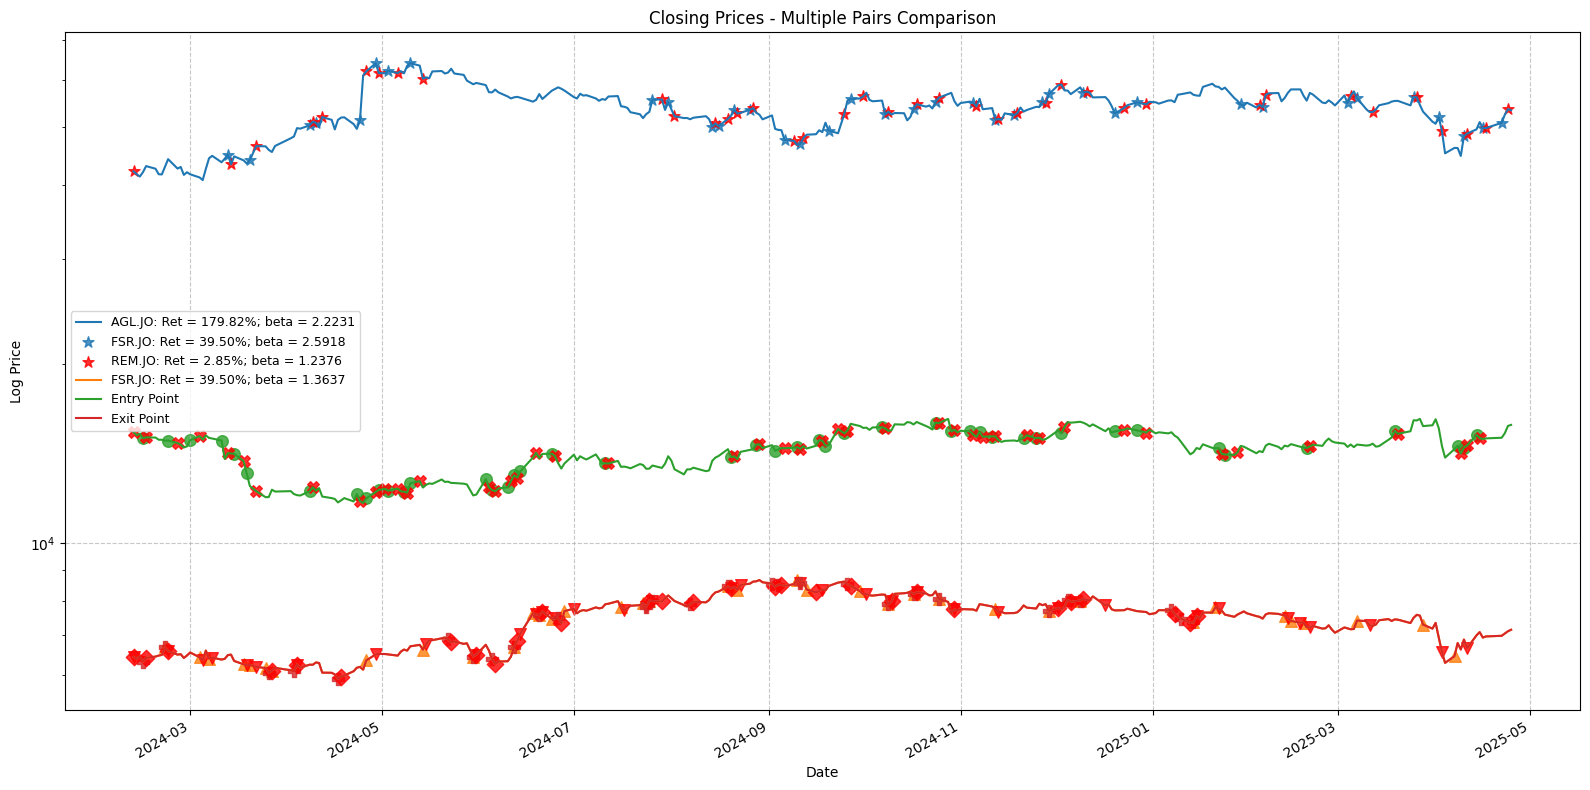

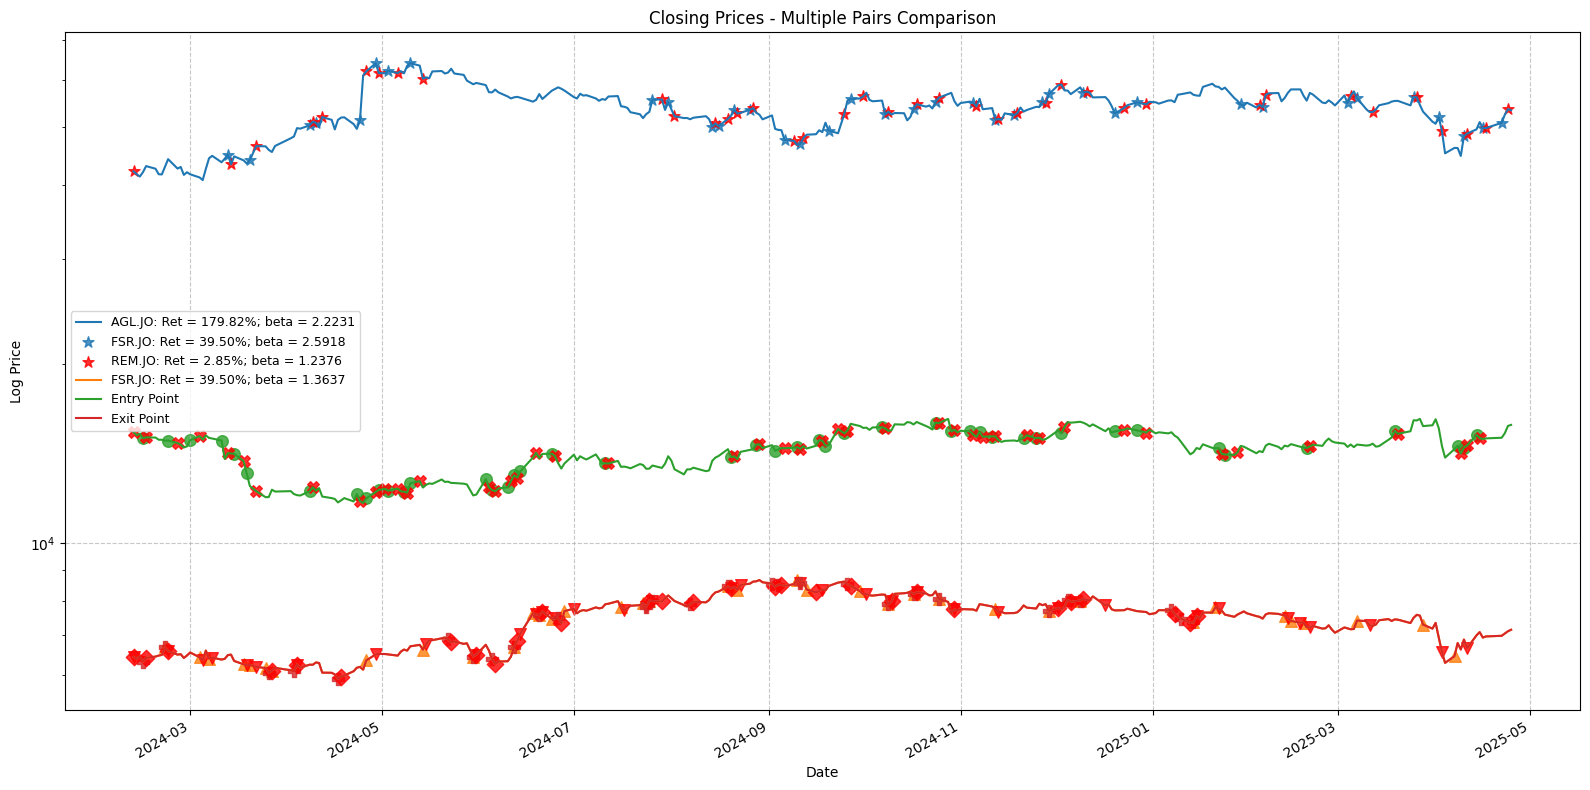

In [79]:
def plot_multiple_pairs_with_dates(pairs_to_plot, figsize=(16, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
    entry_markers = ['*', '^', 'o', 'P']
    exit_markers = ['*', 'v', 'X', 'D']
    
    # Créer une liste pour stocker les handles pour la légende
    legend_handles = []

    for i, pair in enumerate(pairs_to_plot):
        if i >= len(colors): break
            
        # Extraire les données
        x_ticker = pair["X"]
        y_ticker = pair["Y"]
        test_data = pair["test"]
        signals = pair["signals"]
        
        # Utiliser les derniers mois de données
        if len(test_data) > 300:
            test_data = test_data.iloc[-300:]
            signals = signals.iloc[-300:]
        
        # Dates et prix
        dates = test_data.index
        prices = test_data[x_ticker]
        
        # Calculer le rendement
        ret = (prices.iloc[-1] - prices.iloc[0]) / prices.iloc[0] * 100
        
        # Tracer le prix
        color = colors[i % len(colors)]
        line, = ax.plot(dates, prices, color=color, linewidth=1.5)
        legend_handles.append(line)
        
        # Trouver les points d'entrée/sortie
        entry_points = (signals.shift(1) == 0) & (signals != 0)
        exit_points = (signals.shift(1) != 0) & (signals == 0)
        
        entry_dates = dates[entry_points]
        exit_dates = dates[exit_points]
        
        # Tracer les points d'entrée
        if len(entry_dates) > 0:
            entry_values = prices.loc[entry_dates]
            entry_scatter = ax.scatter(entry_dates, entry_values, 
                          color=color, marker=entry_markers[i % len(entry_markers)], s=70, alpha=0.8)
            if i == 0:  # Ajouter à la légende seulement pour la première paire
                legend_handles.append(entry_scatter)
        
        # Tracer les points de sortie
        if len(exit_dates) > 0:
            exit_values = prices.loc[exit_dates]
            exit_scatter = ax.scatter(exit_dates, exit_values, 
                         color='red', marker=exit_markers[i % len(exit_markers)], s=70, alpha=0.8)
            if i == 0:  # Ajouter à la légende seulement pour la première paire
                legend_handles.append(exit_scatter)
    
    # Configurer le graphique
    ax.set_yscale('log')
    ax.set_title("Closing Prices - Multiple Pairs Comparison")
    ax.set_xlabel("Date")
    ax.set_ylabel("Log Price")
    
    # Créer les étiquettes de légende
    legend_labels = []
    for i, pair in enumerate(pairs_to_plot):
        if i >= len(colors): break
        x_ticker = pair["X"]
        ret = (pair["test"][x_ticker].iloc[-1] - pair["test"][x_ticker].iloc[0]) / pair["test"][x_ticker].iloc[0] * 100
        legend_labels.append(f"{x_ticker}: Ret = {ret:.2f}%; beta = {pair['beta']:.4f}")
    
    # Ajouter des étiquettes pour les entrées/sorties (seulement une fois)
    legend_labels.append("Entry Point")
    legend_labels.append("Exit Point")
    
    # Ajouter la légende
    ax.legend(legend_handles, legend_labels, loc='best', fontsize=9)
    
    # Formater l'axe des dates
    plt.gcf().autofmt_xdate()
    
    # Ajouter la grille
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Sélectionner les meilleures paires (pas de betas aberrants)
top_pairs = sorted([p for p in cointegrated_pairs if abs(p['beta']) < 5], 
                   key=lambda p: p['pnl'].iloc[-1], reverse=True)[:4]

# Afficher les meilleures paires
plot_multiple_pairs_with_dates(top_pairs)

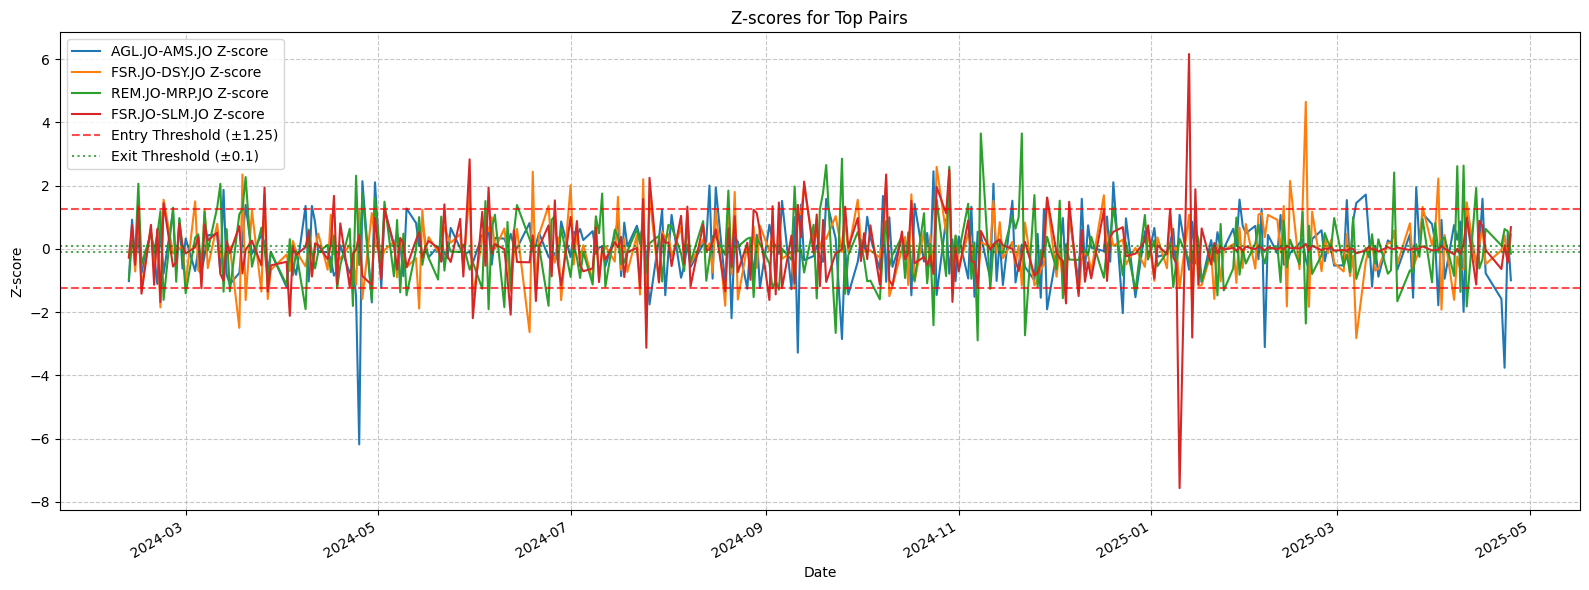

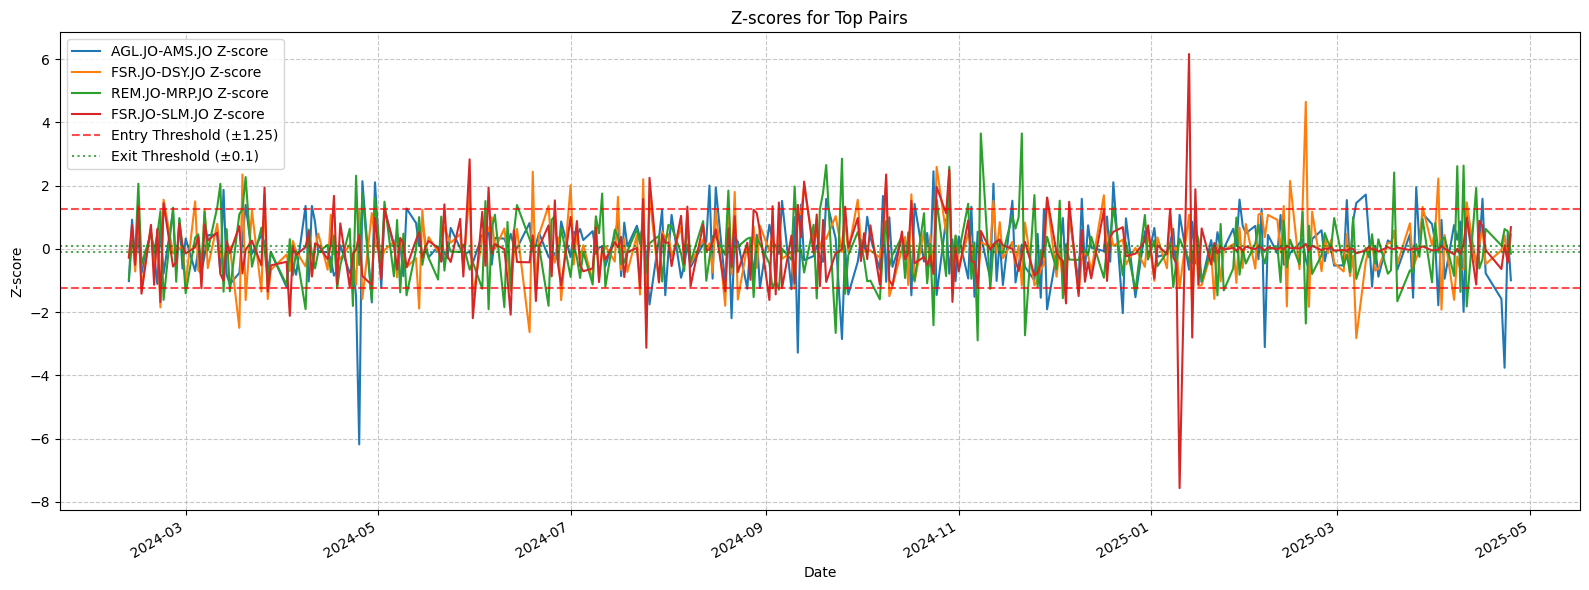

In [80]:
def plot_zscores(pairs_to_plot, figsize=(16, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    
    for i, pair in enumerate(pairs_to_plot):
        if i >= len(colors): break
        
        # Extraire les données
        x_ticker = pair["X"]
        y_ticker = pair["Y"]
        zscore = pair["zscore"]
        
        # Limiter aux derniers mois
        if len(zscore) > 300:
            zscore = zscore.iloc[-300:]
        
        # Tracer le z-score
        ax.plot(zscore.index, zscore, color=colors[i], 
                label=f"{x_ticker}-{y_ticker} Z-score")
    
    # Ajouter les seuils
    ax.axhline(y=1.25, color='r', linestyle='--', alpha=0.7, label='Entry Threshold (±1.25)')
    ax.axhline(y=-1.25, color='r', linestyle='--', alpha=0.7)
    ax.axhline(y=0.1, color='g', linestyle=':', alpha=0.7, label='Exit Threshold (±0.1)')
    ax.axhline(y=-0.1, color='g', linestyle=':', alpha=0.7)
    
    ax.set_title("Z-scores for Top Pairs")
    ax.set_xlabel("Date")
    ax.set_ylabel("Z-score")
    ax.legend(loc='best')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    
    return fig

# Afficher les z-scores
plot_zscores(top_pairs)

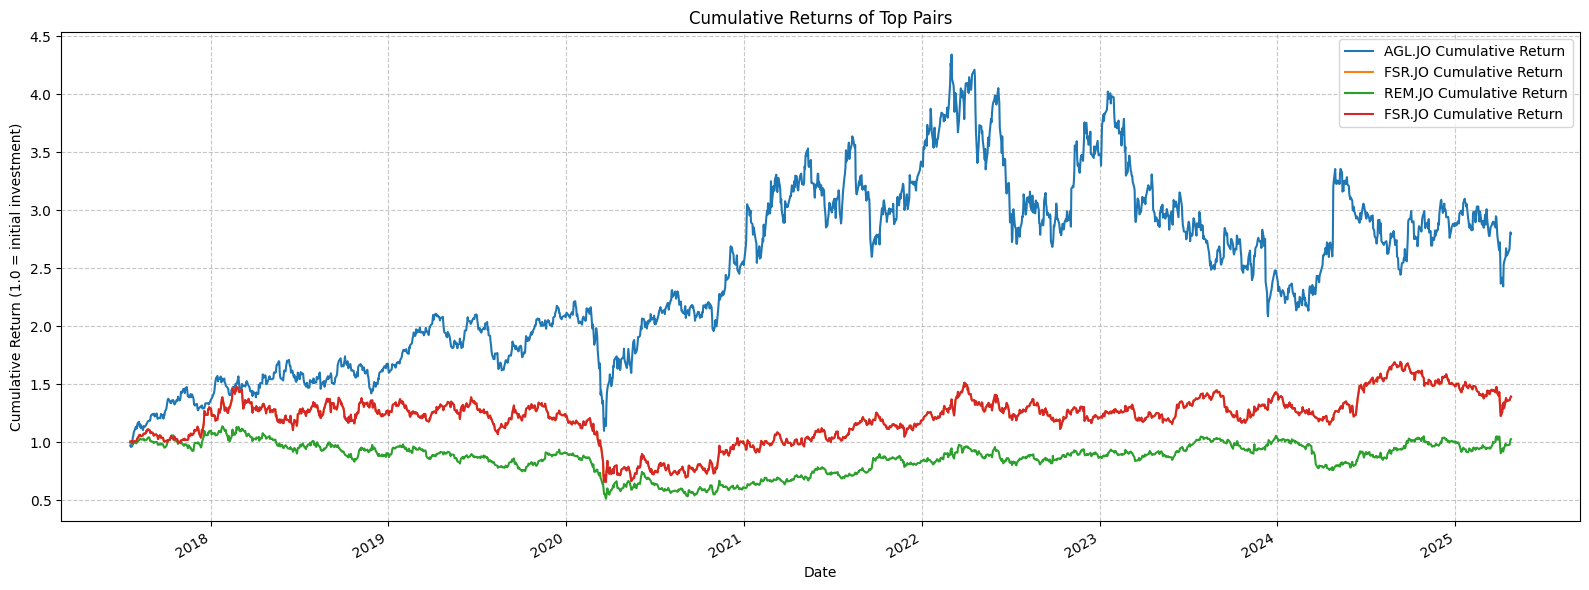

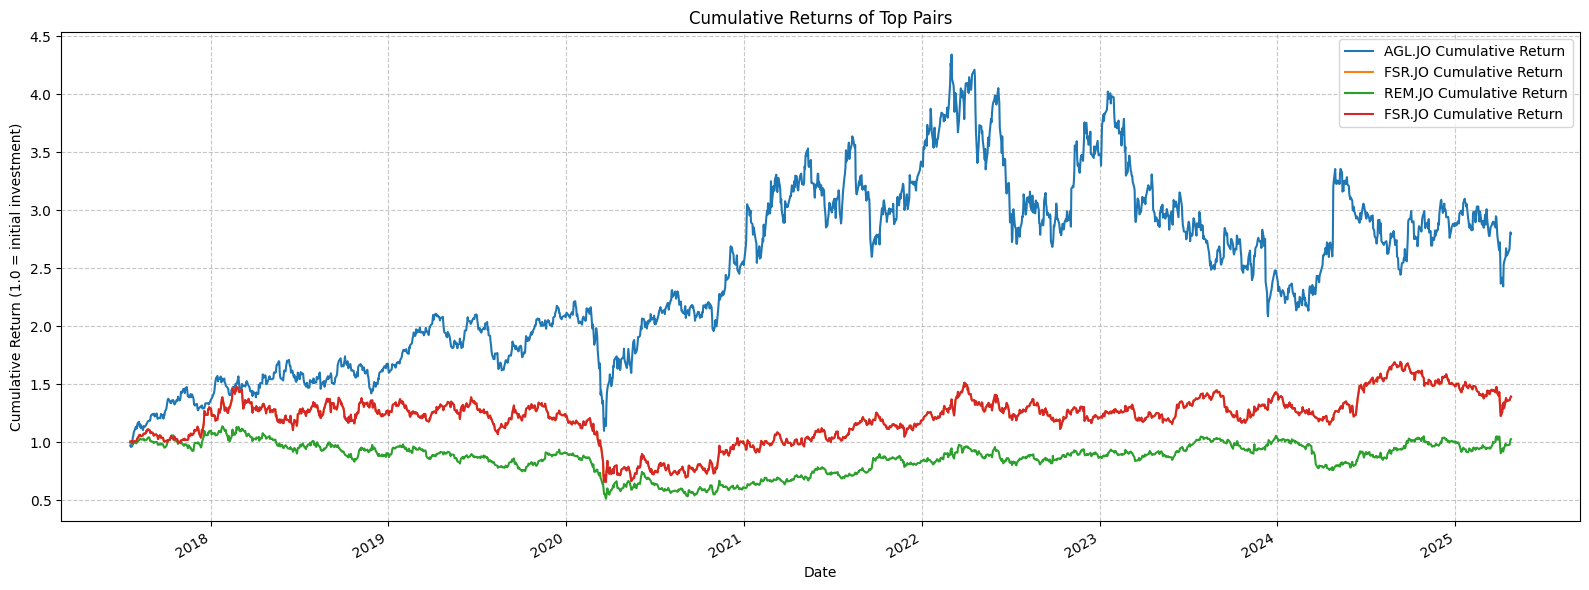

In [81]:
def plot_cumulative_returns(pairs_to_plot, figsize=(16, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    
    for i, pair in enumerate(pairs_to_plot):
        if i >= len(colors): break
        
        # Extraire les données et calculer les rendements
        x_ticker = pair["X"]
        test_data = pair["test"]
        prices = test_data[x_ticker]
        
        # Calculer les rendements quotidiens
        daily_returns = prices.pct_change()
        
        # Calculer les rendements cumulés (commencer à 1.0)
        cumulative_returns = (1 + daily_returns).cumprod()
        
        # Tracer les rendements cumulés
        ax.plot(cumulative_returns.index, cumulative_returns, 
                color=colors[i], label=f"{x_ticker} Cumulative Return")
    
    ax.set_title("Cumulative Returns of Top Pairs")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return (1.0 = initial investment)")
    ax.legend(loc='best')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    
    return fig

# Afficher les rendements cumulés
plot_cumulative_returns(top_pairs)